In [ ]:
import pandas as pd
import numpy as np
import gc
from pandas.core.common import SettingWithCopyWarning
import warnings
from multiprocessing import Pool as Pool
import functools
import logging


def get_keys_for_field(field=None):
    the_dict = {
        'device': [
            'browser',
            'browserSize',
            'browserVersion',
            'deviceCategory',
            'flashVersion',
            'isMobile',
            'language',
            'mobileDeviceBranding',
            'mobileDeviceInfo',
            'mobileDeviceMarketingName',
            'mobileDeviceModel',
            'mobileInputSelector',
            'operatingSystem',
            'operatingSystemVersion',
            'screenColors',
            'screenResolution'
        ],
        'geoNetwork': [
            'city',
            'cityId',
            'continent',
            'country',
            'latitude',
            'longitude',
            'metro',
            'networkDomain',
            'networkLocation',
            'region',
            'subContinent'
        ],
        'totals': [
            'bounces',
            'hits',
            'newVisits',
            'pageviews',
            'transactionRevenue',
            'visits'
        ],
        'trafficSource': [
            'adContent',
            'adwordsClickInfo',
            'campaign',
            'campaignCode',
            'isTrueDirect',
            'keyword',
            'medium',
            'referralPath',
            'source'
        ],
    }

    return the_dict[field]


def apply_func_on_series(data=None, func=None):
    return data.apply(lambda x: func(x))


def multi_apply_func_on_series(df=None, func=None, n_jobs=4):
    p = Pool(n_jobs)
    f_ = p.map(functools.partial(apply_func_on_series, func=func),
               np.array_split(df, n_jobs))
    f_ = pd.concat(f_, axis=0, ignore_index=True)
    p.close()
    p.join()
    return f_.values


def convert_to_dict(x):
    return eval(x.replace('false', 'False')
                .replace('true', 'True')
                .replace('null', 'np.nan'))


def get_dict_field(x_, key_):
    try:
        return x_[key_]
    except KeyError:
        return np.nan


def develop_json_fields(df=None):
    json_fields = ['device', 'geoNetwork', 'totals', 'trafficSource']
    # Get the keys
    for json_field in json_fields:
        # print('Doing Field {}'.format(json_field))
        # Get json field keys to create columns
        the_keys = get_keys_for_field(json_field)
        # Replace the string by a dict
        # print('Transform string to dict')
        df[json_field] = multi_apply_func_on_series(
            df=df[json_field],
            func=convert_to_dict,
            n_jobs=4
        )
        logger.info('{} converted to dict'.format(json_field))
        #         df[json_field] = df[json_field].apply(lambda x: eval(x
        #                                             .replace('false', 'False')
        #                                             .replace('true', 'True')
        #                                             .replace('null', 'np.nan')))
        for k in the_keys:
            # print('Extracting {}'.format(k))
            df[json_field + '.' + k] = df[json_field].apply(lambda x: get_dict_field(x_=x, key_=k))
        del df[json_field]
        gc.collect()
        logger.info('{} fields extracted'.format(json_field))
    return df


def main(nrows=None):
    # Convert train
    train = pd.read_csv('D:/kaggle_compitition/all/train.csv', dtype='object', nrows=nrows, encoding='utf-8')
    train = develop_json_fields(df=train)
    logger.info('Train done')

    # Convert test
    test = pd.read_csv('D:/kaggle_compitition/all/test.csv', dtype='object', nrows=nrows, encoding='utf-8')
    test = develop_json_fields(df=test)
    logger.info('Test done')

    # Check features validity
    for f in train.columns:
        if f not in ['date', 'fullVisitorId', 'sessionId']:
            try:
                train[f] = train[f].astype(np.float64)
                test[f] = test[f].astype(np.float64)
            except (ValueError, TypeError):
                logger.info('{} is a genuine string field'.format(f))
                pass
            except Exception:
                logger.exception('{} enountered an exception'.format(f))
                raise

    logger.info('{}'.format(train['totals.transactionRevenue'].sum()))
    feature_to_drop = []
    for f in train.columns:
        if f not in ['date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue']:
            if train[f].dtype == 'object':
                try:
                    trn, _ = pd.factorize(train[f])
                    tst, _ = pd.factorize(test[f])
                    if (np.std(trn) == 0) | (np.std(tst) == 0):
                        feature_to_drop.append(f)
                        logger.info('No variation in {}'.format(f))
                except TypeError:
                    feature_to_drop.append(f)
                    logger.info('TypeError exception for {}'.format(f))
            else:
                if (np.std(train[f].fillna(0).values) == 0) | (np.std(test[f].fillna(0).values) == 0):
                    feature_to_drop.append(f)
                    logger.info('No variation in {}'.format(f))
    test.drop(feature_to_drop, axis=1, inplace=True)
    train.drop(feature_to_drop, axis=1, inplace=True)
    logger.info('{}'.format(train['totals.transactionRevenue'].sum()))

    for f in train.columns:
        if train[f].dtype == 'object':
            train[f] = train[f].apply(lambda x: try_encode(x))
            test[f] = test[f].apply(lambda x: try_encode(x))

    test.to_csv('extracted_fields_test.gz', compression='gzip', index=False)
    train.to_csv('extracted_fields_train.gz', compression='gzip', index=False)


def try_encode(x):
    """Used to remove any encoding issues within the data"""
    try:
        return x.encode('utf-8', 'surrogateescape').decode('utf-8')
    except AttributeError:
        return np.nan
    except UnicodeEncodeError:
        return np.nan


def get_logger():
    logger_ = logging.getLogger('main')
    logger_.setLevel(logging.DEBUG)
    fh = logging.FileHandler('logging.log')
    fh.setLevel(logging.DEBUG)
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    formatter = logging.Formatter('[%(levelname)s]%(asctime)s:%(name)s:%(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    # add the handlers to the logger
    logger_.addHandler(fh)
    logger_.addHandler(ch)

    return logger_


if __name__ == '__main__':
    logger = get_logger()
    try:
        warnings.simplefilter('error', SettingWithCopyWarning)
        gc.enable()
        logger.info('Process started')
        main(nrows=None)
    except Exception as err:
        logger.exception('Exception occured')
        raise

[INFO]2018-10-15 09:49:26,391:main:Process started


# 2차전

In [31]:
import pandas as pd
import numpy as np

# DRAGONS
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

# plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# pandas / plt options
pd.options.display.max_columns = 999
plt.rcParams['figure.figsize'] = (14, 7)
font = {'family' : 'verdana',
        'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)

# remove warnings
import warnings
warnings.simplefilter("ignore")

# garbage collector
import gc
gc.enable()

In [32]:
train = pd.read_csv('D:/kaggle_compitition/all/extracted_fields_train.gz', dtype={'date': str, 'fullVisitorId': str, 'sessionId':str, 'visitId': np.int64})
test = pd.read_csv('D:/kaggle_compitition/all/extracted_fields_test.gz', dtype={'date': str, 'fullVisitorId': str, 'sessionId':str, 'visitId': np.int64})
train.shape, test.shape

((903653, 30), (804684, 30))

In [33]:
# Getting data from leak
train_store_1 = pd.read_csv('D:/kaggle_compitition/all/Train_external_data.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
train_store_2 = pd.read_csv('D:/kaggle_compitition/all/Train_external_data_2.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
test_store_1 = pd.read_csv('D:/kaggle_compitition/all/Test_external_data.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
test_store_2 = pd.read_csv('D:/kaggle_compitition/all/Test_external_data_2.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})

In [34]:
# Getting VisitId from Google Analytics...
for df in [train_store_1, train_store_2, test_store_1, test_store_2]:
    df["visitId"] = df["Client Id"].apply(lambda x: x.split('.', 1)[1]).astype(np.int64)

In [35]:
# Merge with train/test data
train = train.merge(pd.concat([train_store_1, train_store_2], sort=False), how="left", on="visitId")
test = test.merge(pd.concat([test_store_1, test_store_2], sort=False), how="left", on="visitId")

# Drop Client Id
for df in [train, test]:
    df.drop("Client Id", 1, inplace=True)

In [36]:
# Cleaning Revenue
for df in [train, test]:
    df["Revenue"].fillna('$', inplace=True)
    df["Revenue"] = df["Revenue"].apply(lambda x: x.replace('$', '').replace(',', ''))
    df["Revenue"] = pd.to_numeric(df["Revenue"], errors="coerce")
    df["Revenue"].fillna(0.0, inplace=True)

In [37]:
for df in [train_store_1, train_store_2, test_store_1, test_store_2]:
    del df
gc.collect()

378

In [38]:
train.visitStartTime = pd.to_datetime(train.visitStartTime, unit='s')
test.visitStartTime = pd.to_datetime(test.visitStartTime, unit='s')
train["date"] = train.visitStartTime
test["date"] = test.visitStartTime

In [39]:
train.set_index("visitStartTime", inplace=True)
test.set_index("visitStartTime", inplace=True)
train.sort_index(inplace=True)
test.sort_index(inplace=True)

In [40]:
def clearRare(columnname, limit = 1000):
    # you may search for rare categories in train, train&test, or just test
    #vc = pd.concat([train[columnname], test[columnname]], sort=False).value_counts()
    vc = test[columnname].value_counts()
    
    common = vc > limit
    common = set(common.index[common].values)
    print("Set", sum(vc <= limit), columnname, "categories to 'other';", end=" ")
    
    train.loc[train[columnname].map(lambda x: x not in common), columnname] = 'other'
    test.loc[test[columnname].map(lambda x: x not in common), columnname] = 'other'
    print("now there are", train[columnname].nunique(), "categories in train")

In [41]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [42]:
clearRare("device.browser")
clearRare("device.operatingSystem")
clearRare("geoNetwork.country")
clearRare("geoNetwork.city")
clearRare("geoNetwork.metro")
clearRare("geoNetwork.networkDomain")
clearRare("geoNetwork.region")
clearRare("geoNetwork.subContinent")
clearRare("trafficSource.adContent")
clearRare("trafficSource.campaign")
clearRare("trafficSource.keyword")
clearRare("trafficSource.medium")
clearRare("trafficSource.referralPath")
clearRare("trafficSource.source")

Set 98 device.browser categories to 'other'; now there are 11 categories in train
Set 15 device.operatingSystem categories to 'other'; now there are 8 categories in train
Set 160 geoNetwork.country categories to 'other'; now there are 60 categories in train
Set 656 geoNetwork.city categories to 'other'; now there are 77 categories in train
Set 86 geoNetwork.metro categories to 'other'; now there are 24 categories in train
Set 25689 geoNetwork.networkDomain categories to 'other'; now there are 62 categories in train
Set 314 geoNetwork.region categories to 'other'; now there are 62 categories in train
Set 5 geoNetwork.subContinent categories to 'other'; now there are 19 categories in train
Set 46 trafficSource.adContent categories to 'other'; now there are 4 categories in train
Set 23 trafficSource.campaign categories to 'other'; now there are 5 categories in train
Set 2409 trafficSource.keyword categories to 'other'; now there are 8 categories in train
Set 1 trafficSource.medium categor

In [43]:
# Clearing leaked data:
for df in [train, test]:
    df["Avg. Session Duration"][df["Avg. Session Duration"] == 0] = "00:00:00"
    df["Avg. Session Duration"] = df["Avg. Session Duration"].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
    df["Bounce Rate"] = df["Bounce Rate"].astype(str).apply(lambda x: x.replace('%', '')).astype(float)
    df["Goal Conversion Rate"] = df["Goal Conversion Rate"].astype(str).apply(lambda x: x.replace('%', '')).astype(float)

# Features

In [44]:
for df in [train, test]:
    # remember these features were equal, but not always? May be it means something...
    df["id_incoherence"] = pd.to_datetime(df.visitId, unit='s') != df.date
    # remember visitId dublicates?
    df["visitId_dublicates"] = df.visitId.map(df.visitId.value_counts())
    # remember session dublicates?
    df["session_dublicates"] = df.sessionId.map(df.sessionId.value_counts())

In [45]:
for df in [train, test]:
    df['weekday'] = df['date'].dt.dayofweek.astype(object)
    df['time'] = df['date'].dt.second + df['date'].dt.minute*60 + df['date'].dt.hour*3600
    #df['month'] = df['date'].dt.month   # it must not be included in features during learning!
    df['day'] = df['date'].dt.date       # it must not be included in features during learning!

In [46]:
df = pd.concat([train, test])
df.sort_values(['fullVisitorId', 'date'], ascending=True, inplace=True)
df['prev_session'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(1)).astype(np.int64) // 1e9 // 60 // 60
df['next_session'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(-1)).astype(np.int64) // 1e9 // 60 // 60
df.sort_index(inplace=True)

train = df[:len(train)]
test = df[len(train):]

In [47]:
for df in [train, test]:
    df['source.country'] = df['trafficSource.source'] + '_' + df['geoNetwork.country']
    df['campaign.medium'] = df['trafficSource.campaign'] + '_' + df['trafficSource.medium']
    df['browser.category'] = df['device.browser'] + '_' + df['device.deviceCategory']
    df['browser.os'] = df['device.browser'] + '_' + df['device.operatingSystem']

In [48]:
for df in [train, test]:
    df['device_deviceCategory_channelGrouping'] = df['device.deviceCategory'] + "_" + df['channelGrouping']
    df['channelGrouping_browser'] = df['device.browser'] + "_" + df['channelGrouping']
    df['channelGrouping_OS'] = df['device.operatingSystem'] + "_" + df['channelGrouping']
    
    for i in ['geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country','geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region','geoNetwork.subContinent']:
        for j in ['device.browser','device.deviceCategory', 'device.operatingSystem', 'trafficSource.source']:
            df[i + "_" + j] = df[i] + "_" + df[j]
    
    df['content.source'] = df['trafficSource.adContent'].astype(str) + "_" + df['source.country']
    df['medium.source'] = df['trafficSource.medium'] + "_" + df['source.country']

In [49]:
for feature in ["totals.hits", "totals.pageviews"]:
    info = pd.concat([train, test], sort=False).groupby("fullVisitorId")[feature].mean()
    train["usermean_" + feature] = train.fullVisitorId.map(info)
    test["usermean_" + feature] = test.fullVisitorId.map(info)
    
for feature in ["visitNumber"]:
    info = pd.concat([train, test], sort=False).groupby("fullVisitorId")[feature].max()
    train["usermax_" + feature] = train.fullVisitorId.map(info)
    test["usermax_" + feature] = test.fullVisitorId.map(info)

In [50]:
excluded = ['date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 'visitId', 'visitStartTime', 
            'month', 'day', 'help']

cat_cols = [f for f in train.columns if (train[f].dtype == 'object' and f not in excluded)]
real_cols = [f for f in train.columns if (not f in cat_cols and f not in excluded)]

In [51]:
train[cat_cols].nunique()

channelGrouping                                       8
device.browser                                       11
device.deviceCategory                                 3
device.operatingSystem                                8
geoNetwork.city                                      77
geoNetwork.continent                                  6
geoNetwork.country                                   60
geoNetwork.metro                                     24
geoNetwork.networkDomain                             62
geoNetwork.region                                    62
geoNetwork.subContinent                              19
trafficSource.adContent                               4
trafficSource.campaign                                5
trafficSource.keyword                                 8
trafficSource.medium                                  7
trafficSource.referralPath                           17
trafficSource.source                                 22
weekday                                         

In [52]:
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

In [53]:
for col in real_cols:
    train[col] = train[col].astype(float)
    test[col] = test[col].astype(float)

In [54]:
train[real_cols + cat_cols].head()

,visitNumber,device.isMobile,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,trafficSource.isTrueDirect,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate,id_incoherence,visitId_dublicates,session_dublicates,time,prev_session,next_session,usermean_totals.hits,usermean_totals.pageviews,usermax_visitNumber,channelGrouping,device.browser,device.deviceCategory,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,trafficSource.adContent,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,weekday,source.country,campaign.medium,browser.category,browser.os,device_deviceCategory_channelGrouping,channelGrouping_browser,channelGrouping_OS,geoNetwork.city_device.browser,geoNetwork.city_device.deviceCategory,geoNetwork.city_device.operatingSystem,geoNetwork.city_trafficSource.source,geoNetwork.continent_device.browser,geoNetwork.continent_device.deviceCategory,geoNetwork.continent_device.operatingSystem,geoNetwork.continent_trafficSource.source,geoNetwork.country_device.browser,geoNetwork.country_device.deviceCategory,geoNetwork.country_device.operatingSystem,geoNetwork.country_trafficSource.source,geoNetwork.metro_device.browser,geoNetwork.metro_device.deviceCategory,geoNetwork.metro_device.operatingSystem,geoNetwork.metro_trafficSource.source,geoNetwork.networkDomain_device.browser,geoNetwork.networkDomain_device.deviceCategory,geoNetwork.networkDomain_device.operatingSystem,geoNetwork.networkDomain_trafficSource.source,geoNetwork.region_device.browser,geoNetwork.region_device.deviceCategory,geoNetwork.region_device.operatingSystem,geoNetwork.region_trafficSource.source,geoNetwork.subContinent_device.browser,geoNetwork.subContinent_device.deviceCategory,geoNetwork.subContinent_device.operatingSystem,geoNetwork.subContinent_trafficSource.source,content.source,medium.source
visitStartTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-08-01 07:00:12,3.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,25212.0,-2562048.0,-2562048.0,1.0,1.0,3.0,2,7,1,6,75,2,57,22,0,61,8,0,1,4,0,24,0,0,57,1,25,37,10,62,50,831,226,564,1359,31,7,22,37,676,172,459,1032,252,67,170,442,7,1,6,0,701,184,471,1103,103,25,70,153,57,57
2016-08-01 07:04:26,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,25466.0,-2562048.0,-2562048.0,1.0,1.0,1.0,7,1,0,5,75,3,52,22,51,61,11,0,1,4,6,14,21,0,1084,7,3,6,7,14,47,825,225,563,1380,37,9,29,80,610,156,418,956,246,66,169,463,559,153,405,930,695,183,470,1124,133,33,93,239,1084,1237
2016-08-01 07:04:41,1.0,1.0,0.0,5.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,25481.0,-2562048.0,-2562048.0,5.0,5.0,1.0,4,11,2,1,75,2,57,22,0,61,8,0,1,3,4,24,8,0,518,5,35,49,20,86,12,835,227,559,1367,35,8,17,45,680,173,454,1040,256,68,165,450,11,2,1,8,705,185,466,1111,107,26,65,161,518,393
2016-08-01 07:06:01,1.0,0.0,0.0,9.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,25561.0,-2562048.0,-2562048.0,9.0,7.0,1.0,4,1,0,5,75,2,8,22,8,61,8,0,1,3,4,24,8,0,469,5,3,6,4,11,44,825,225,563,1367,25,6,21,45,96,24,69,149,246,66,169,450,90,24,69,151,695,183,470,1111,97,24,69,161,469,344
2016-08-01 07:06:10,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,25570.0,-2562048.0,-2562048.0,1.0,1.0,1.0,2,1,0,5,76,3,36,0,29,62,11,0,1,4,0,24,0,0,36,1,3,6,2,9,42,837,228,571,1381,37,9,29,59,422,108,290,651,1,0,5,0,319,87,233,527,707,186,478,1125,133,33,93,218,36,36


In [55]:
for to_del in ["date", "sessionId", "visitId", "day"]:
    del train[to_del]
    del test[to_del]

# Preparing validation

In [56]:
excluded = ['date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 'visitId', 'visitStartTime', "month", "help"]

cat_cols = [f for f in train.columns if (train[f].dtype == 'int64' and f not in excluded)]
real_cols = [f for f in train.columns if (not f in cat_cols and f not in excluded)]

In [57]:
from sklearn.metrics import mean_squared_error
def score(data, y):
    validation_res = pd.DataFrame(
    {"fullVisitorId": data["fullVisitorId"].values,
     "transactionRevenue": data["totals.transactionRevenue"].values,
     "predictedRevenue": np.expm1(y)})

    validation_res = validation_res.groupby("fullVisitorId")["transactionRevenue", "predictedRevenue"].sum().reset_index()
    return np.sqrt(mean_squared_error(np.log1p(validation_res["transactionRevenue"].values), 
                                     np.log1p(validation_res["predictedRevenue"].values)))

In [58]:
from sklearn.model_selection import GroupKFold

class KFoldValidation():
    def __init__(self, data, n_splits=5):
        unique_vis = np.array(sorted(data['fullVisitorId'].astype(str).unique()))
        folds = GroupKFold(n_splits)
        ids = np.arange(data.shape[0])
        
        self.fold_ids = []
        for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
            self.fold_ids.append([
                    ids[data['fullVisitorId'].astype(str).isin(unique_vis[trn_vis])],
                    ids[data['fullVisitorId'].astype(str).isin(unique_vis[val_vis])]
                ])
            
    def validate(self, train, test, features, model, name="", prepare_stacking=False, 
                 fit_params={"early_stopping_rounds": 50, "verbose": 100, "eval_metric": "rmse"}):
        model.FI = pd.DataFrame(index=features)
        full_score = 0
        
        if prepare_stacking:
            test[name] = 0
            train[name] = np.NaN
        
        for fold_id, (trn, val) in enumerate(self.fold_ids):
            devel = train[features].iloc[trn]
            y_devel = np.log1p(train["totals.transactionRevenue"].iloc[trn])
            valid = train[features].iloc[val]
            y_valid = np.log1p(train["totals.transactionRevenue"].iloc[val])
                       
            print("Fold ", fold_id, ":")
            model.fit(devel, y_devel, eval_set=[(valid, y_valid)], **fit_params)
            
            if len(model.feature_importances_) == len(features):  # some bugs in catboost?
                model.FI['fold' + str(fold_id)] = model.feature_importances_ / model.feature_importances_.sum()

            predictions = model.predict(valid)
            predictions[predictions < 0] = 0
            print("Fold ", fold_id, " error: ", mean_squared_error(y_valid, predictions)**0.5)
            
            fold_score = score(train.iloc[val], predictions)
            full_score += fold_score / len(self.fold_ids)
            print("Fold ", fold_id, " score: ", fold_score)
            
            if prepare_stacking:
                train[name].iloc[val] = predictions
                
                test_predictions = model.predict(test[features])
                test_predictions[test_predictions < 0] = 0
                test[name] += test_predictions / len(self.fold_ids)
                
        print("Final score: ", full_score)
        return full_score

In [59]:
Kfolder = KFoldValidation(train)

In [60]:
lgbmodel = lgb.LGBMRegressor(n_estimators=1000, objective="regression", metric="rmse", num_leaves=31, min_child_samples=100,
                      learning_rate=0.03, bagging_fraction=0.7, feature_fraction=0.5, bagging_frequency=5, 
                      bagging_seed=2019, subsample=.9, colsample_bytree=.9, use_best_model=True)
Kfolder.validate(train, test, real_cols + cat_cols, lgbmodel, "lgbpred", prepare_stacking=True)

Fold  0 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.6217
[200]	valid_0's rmse: 1.59395
[300]	valid_0's rmse: 1.58416
[400]	valid_0's rmse: 1.58092
[500]	valid_0's rmse: 1.57862
[600]	valid_0's rmse: 1.57718
[700]	valid_0's rmse: 1.57635
[800]	valid_0's rmse: 1.57583
Early stopping, best iteration is:
[762]	valid_0's rmse: 1.57581
Fold  0  error:  1.574468039843558
Fold  0  score:  1.5555508508875122
Fold  1 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.59479
[200]	valid_0's rmse: 1.5714
[300]	valid_0's rmse: 1.56371
[400]	valid_0's rmse: 1.55975
[500]	valid_0's rmse: 1.5579
[600]	valid_0's rmse: 1.55671
[700]	valid_0's rmse: 1.55582
[800]	valid_0's rmse: 1.55549
Early stopping, best iteration is:
[781]	valid_0's rmse: 1.55525
Fold  1  error:  1.5540710953591002
Fold  1  score:  1.5564294397302254
Fold  2 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.60651
[200

1.5501460885179181

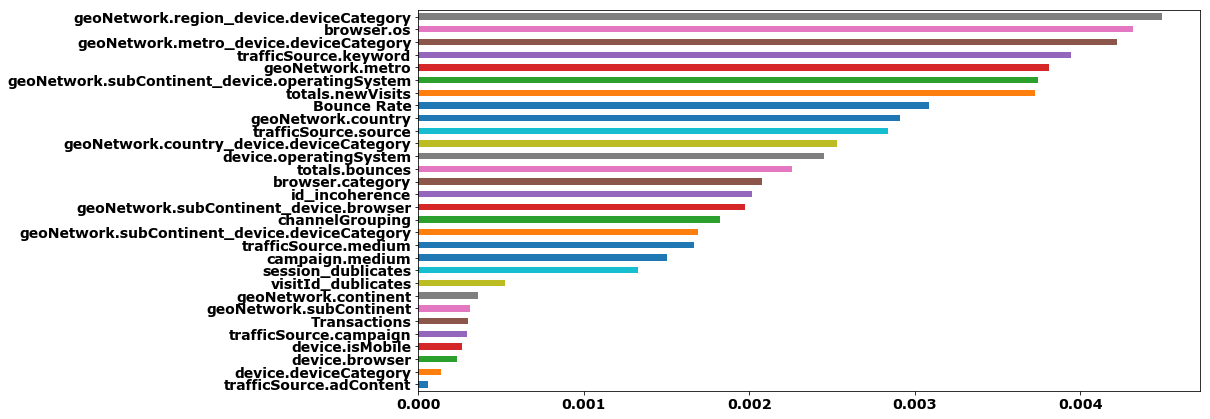

In [61]:
lgbmodel.FI.mean(axis=1).sort_values()[:30].plot(kind="barh")

In [62]:
def create_user_df(df):
    agg_data = df[real_cols + cat_cols + ['fullVisitorId']].groupby('fullVisitorId').mean()
    
    pred_list = df[['fullVisitorId', 'lgbpred']].groupby('fullVisitorId').apply(lambda visitor_df: list(visitor_df.lgbpred))\
        .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})
    all_predictions = pd.DataFrame(list(pred_list.values), index=agg_data.index)
    feats = all_predictions.columns

    all_predictions['t_mean'] = all_predictions.mean(axis=1)
    all_predictions['t_median'] = all_predictions.median(axis=1)   # including t_mean as one of the elements? well, ok
    all_predictions['t_sum_log'] = all_predictions.sum(axis=1)
    all_predictions['t_sum_act'] = all_predictions.fillna(0).sum(axis=1)
    all_predictions['t_nb_sess'] = all_predictions.isnull().sum(axis=1)

    full_data = pd.concat([agg_data, all_predictions], axis=1).astype(float)
    full_data['fullVisitorId'] = full_data.index
    del agg_data, all_predictions
    gc.collect()
    return full_data

In [63]:
user_train = create_user_df(train)
user_test = create_user_df(test)
features = list(user_train.columns)[:-1]  # don't include "fullVisitorId"
user_train["totals.transactionRevenue"] = train[['fullVisitorId', 'totals.transactionRevenue']].groupby('fullVisitorId').sum()
for f in features:
    if f not in user_test.columns:
        user_test[f] = np.nan

In [64]:
Kfolder = KFoldValidation(user_train)

In [65]:
lgbmodel = lgb.LGBMRegressor(n_estimators=1000, objective="regression", metric="rmse", num_leaves=31, min_child_samples=100,
                      learning_rate=0.03, bagging_fraction=0.7, feature_fraction=0.5, bagging_frequency=5, 
                      bagging_seed=2019, subsample=.9, colsample_bytree=.9,
                            use_best_model=True)

In [66]:
Kfolder.validate(user_train, user_test, features, lgbmodel, name="lgbfinal", prepare_stacking=True)

Fold  0 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.50389
[200]	valid_0's rmse: 1.4974
Early stopping, best iteration is:
[209]	valid_0's rmse: 1.49724
Fold  0  error:  1.496954331853478
Fold  0  score:  1.496954331853478
Fold  1 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.50961
Early stopping, best iteration is:
[144]	valid_0's rmse: 1.50648
Fold  1  error:  1.5063903426869982
Fold  1  score:  1.5063903426869982
Fold  2 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.50781
[200]	valid_0's rmse: 1.50259
Early stopping, best iteration is:
[176]	valid_0's rmse: 1.50249
Fold  2  error:  1.5023974143144654
Fold  2  score:  1.5023974143144654
Fold  3 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.48405
[200]	valid_0's rmse: 1.47826
Early stopping, best iteration is:
[216]	valid_0's rmse: 1.47783
Fold  3  error:  1.4776875493

1.4982879160319291

In [67]:
xgbmodel = xgb.XGBRegressor(max_depth=22, learning_rate=0.02, n_estimators=1000, 
                                         objective='reg:linear', gamma=1.45, seed=2019, silent=False,
                                        subsample=0.67, colsample_bytree=0.054, colsample_bylevel=0.50)

In [68]:
Kfolder.validate(user_train, user_test, features, xgbmodel, name="xgbfinal", prepare_stacking=True)

Fold  0 :
[10:19:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 630 extra nodes, 6 pruned nodes, max_depth=19
[0]	validation_0-rmse:2.10082
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10:19:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4158 extra nodes, 122 pruned nodes, max_depth=22
[10:19:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3762 extra nodes, 4 pruned nodes, max_depth=22
[10:19:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2372 extra nodes, 182 pruned nodes, max_depth=22
[10:19:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 2 pruned nodes, max_depth=15
[10:19:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 2

[10:19:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2900 extra nodes, 494 pruned nodes, max_depth=22
[10:19:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6402 extra nodes, 1828 pruned nodes, max_depth=22
[10:20:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1868 extra nodes, 252 pruned nodes, max_depth=22
[10:20:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1518 extra nodes, 258 pruned nodes, max_depth=20
[10:20:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3106 extra nodes, 958 pruned nodes, max_depth=22
[10:20:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4470 extra nodes, 1592 pruned nodes, max_depth=22
[10:20:03] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[10:20:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 800 extra nodes, 274 pruned nodes, max_depth=22
[10:20:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 30 pruned nodes, max_depth=20
[10:20:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 606 pruned nodes, max_depth=22
[10:20:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3282 extra nodes, 1124 pruned nodes, max_depth=22
[10:20:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1720 extra nodes, 2006 pruned nodes, max_depth=22
[10:20:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3086 extra nodes, 1318 pruned nodes, max_depth=20
[10:20:42] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[10:21:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1808 extra nodes, 2142 pruned nodes, max_depth=22
[10:21:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6014 extra nodes, 6006 pruned nodes, max_depth=22
[10:21:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2248 extra nodes, 4818 pruned nodes, max_depth=22
[10:21:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2718 extra nodes, 5594 pruned nodes, max_depth=22
[10:21:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2010 extra nodes, 3552 pruned nodes, max_depth=22
[10:21:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4506 extra nodes, 2468 pruned nodes, max_depth=22
[10:21:24] C:\Users\Administrator\Desktop\xgboost\src\tree

[10:22:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 30 pruned nodes, max_depth=22
[10:22:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3188 extra nodes, 2450 pruned nodes, max_depth=22
[10:22:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 38 pruned nodes, max_depth=18
[10:22:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1056 extra nodes, 656 pruned nodes, max_depth=22
[10:22:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4918 extra nodes, 3696 pruned nodes, max_depth=22
[10:22:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5708 extra nodes, 17104 pruned nodes, max_depth=22
[10:22:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[10:22:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1180 extra nodes, 580 pruned nodes, max_depth=22
[10:22:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 2840 pruned nodes, max_depth=22
[10:22:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5130 extra nodes, 7300 pruned nodes, max_depth=22
[10:22:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 392 pruned nodes, max_depth=22
[10:22:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 1376 pruned nodes, max_depth=19
[10:22:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1480 extra nodes, 3140 pruned nodes, max_depth=22
[10:22:47] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[10:23:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1664 extra nodes, 2534 pruned nodes, max_depth=22
[10:23:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 188 pruned nodes, max_depth=13
[10:23:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4102 extra nodes, 5880 pruned nodes, max_depth=22
[10:23:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 596 extra nodes, 478 pruned nodes, max_depth=22
[10:23:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 910 extra nodes, 694 pruned nodes, max_depth=22
[10:23:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1768 extra nodes, 686 pruned nodes, max_depth=21
[10:23:29] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[10:24:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5020 extra nodes, 7752 pruned nodes, max_depth=22
[10:24:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 7496 extra nodes, 17318 pruned nodes, max_depth=22
[10:24:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 102 pruned nodes, max_depth=20
[10:24:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 888 extra nodes, 882 pruned nodes, max_depth=17
[10:24:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2320 extra nodes, 3306 pruned nodes, max_depth=22
[10:24:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5688 extra nodes, 2448 pruned nodes, max_depth=22
[10:24:13] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[10:24:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1100 extra nodes, 414 pruned nodes, max_depth=22
[10:24:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4558 extra nodes, 18906 pruned nodes, max_depth=22
[10:24:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1412 extra nodes, 766 pruned nodes, max_depth=22
[10:24:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2200 extra nodes, 2074 pruned nodes, max_depth=22
[10:24:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2384 extra nodes, 2620 pruned nodes, max_depth=22
[10:24:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6386 extra nodes, 13458 pruned nodes, max_depth=22
[10:24:53] C:\Users\Administrator\Desktop\xgboost\src\tree

[10:27:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=14
[10:27:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1828 extra nodes, 38 pruned nodes, max_depth=22
[10:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6198 extra nodes, 80 pruned nodes, max_depth=22
[10:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=16
[10:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3754 extra nodes, 66 pruned nodes, max_depth=22
[10:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3250 extra nodes, 162 pruned nodes, max_depth=22
[10:27:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.c

[10:28:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6432 extra nodes, 1470 pruned nodes, max_depth=22
[10:28:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2418 extra nodes, 474 pruned nodes, max_depth=22
[10:28:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3284 extra nodes, 850 pruned nodes, max_depth=22
[10:28:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2414 extra nodes, 806 pruned nodes, max_depth=21
[10:28:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4010 extra nodes, 1384 pruned nodes, max_depth=22
[10:28:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3892 extra nodes, 1060 pruned nodes, max_depth=22
[10:28:16] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[10:28:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3444 extra nodes, 928 pruned nodes, max_depth=22
[10:28:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2964 extra nodes, 2416 pruned nodes, max_depth=22
[10:28:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 744 extra nodes, 238 pruned nodes, max_depth=18
[10:28:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6542 extra nodes, 5734 pruned nodes, max_depth=22
[10:28:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4410 extra nodes, 2212 pruned nodes, max_depth=22
[10:28:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 576 extra nodes, 206 pruned nodes, max_depth=17
[10:28:55] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[10:29:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1364 extra nodes, 860 pruned nodes, max_depth=22
[10:29:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 7708 extra nodes, 7284 pruned nodes, max_depth=22
[10:29:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1048 extra nodes, 1346 pruned nodes, max_depth=22
[10:29:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6666 extra nodes, 7522 pruned nodes, max_depth=22
[10:29:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4058 extra nodes, 4474 pruned nodes, max_depth=22
[10:29:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2248 extra nodes, 4834 pruned nodes, max_depth=22
[10:29:38] C:\Users\Administrator\Desktop\xgboost\src\tree\

[10:30:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2028 extra nodes, 4154 pruned nodes, max_depth=19
[10:30:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 42 pruned nodes, max_depth=12
[10:30:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4850 extra nodes, 2736 pruned nodes, max_depth=22
[10:30:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 7514 extra nodes, 9148 pruned nodes, max_depth=22
[10:30:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5252 extra nodes, 4306 pruned nodes, max_depth=22
[10:30:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5426 extra nodes, 2128 pruned nodes, max_depth=22
[10:30:17] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[10:30:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1072 extra nodes, 864 pruned nodes, max_depth=22
[10:30:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 40 pruned nodes, max_depth=15
[10:30:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3524 extra nodes, 7984 pruned nodes, max_depth=22
[10:30:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 858 extra nodes, 802 pruned nodes, max_depth=22
[10:30:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2034 extra nodes, 594 pruned nodes, max_depth=22
[10:30:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1166 extra nodes, 1168 pruned nodes, max_depth=22
[10:30:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater

[10:31:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 554 extra nodes, 304 pruned nodes, max_depth=17
[10:31:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 7402 extra nodes, 15604 pruned nodes, max_depth=22
[10:31:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2642 extra nodes, 3414 pruned nodes, max_depth=22
[10:31:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2068 extra nodes, 500 pruned nodes, max_depth=19
[10:31:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4156 extra nodes, 10906 pruned nodes, max_depth=22
[10:31:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 668 extra nodes, 904 pruned nodes, max_depth=22
[10:31:45] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[10:32:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 7520 extra nodes, 14694 pruned nodes, max_depth=22
[10:32:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4912 extra nodes, 9248 pruned nodes, max_depth=22
[10:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2480 extra nodes, 3714 pruned nodes, max_depth=22
[10:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 470 pruned nodes, max_depth=22
[10:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 974 extra nodes, 406 pruned nodes, max_depth=20
[10:32:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6016 extra nodes, 12284 pruned nodes, max_depth=22
[10:32:34] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[10:33:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6042 extra nodes, 14524 pruned nodes, max_depth=22
[10:33:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 78 pruned nodes, max_depth=17
[10:33:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3638 extra nodes, 5628 pruned nodes, max_depth=22
[10:33:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2722 extra nodes, 5180 pruned nodes, max_depth=22
[10:33:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2066 extra nodes, 2488 pruned nodes, max_depth=22
[10:33:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 778 extra nodes, 1770 pruned nodes, max_depth=22
[10:33:18] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[10:33:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 274 pruned nodes, max_depth=19
[10:33:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 104 pruned nodes, max_depth=20
[10:33:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 814 extra nodes, 1150 pruned nodes, max_depth=22
[10:33:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3730 extra nodes, 12254 pruned nodes, max_depth=22
[10:33:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 540 extra nodes, 300 pruned nodes, max_depth=19
[10:33:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 20 pruned nodes, max_depth=10
[10:33:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pr

[10:34:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 894 pruned nodes, max_depth=22
[10:34:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 122 pruned nodes, max_depth=19
[10:34:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3604 extra nodes, 7684 pruned nodes, max_depth=22
[10:34:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 554 extra nodes, 542 pruned nodes, max_depth=22
[10:34:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1270 extra nodes, 3532 pruned nodes, max_depth=22
[10:34:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6402 extra nodes, 11876 pruned nodes, max_depth=22
[10:34:38] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[10:35:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4704 extra nodes, 7988 pruned nodes, max_depth=22
[10:35:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1368 extra nodes, 1588 pruned nodes, max_depth=22
[10:35:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 936 extra nodes, 1630 pruned nodes, max_depth=22
[10:35:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1910 extra nodes, 7724 pruned nodes, max_depth=22
[10:35:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 536 extra nodes, 914 pruned nodes, max_depth=22
[10:35:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2298 extra nodes, 6592 pruned nodes, max_depth=22
[10:35:21] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[10:38:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1926 extra nodes, 584 pruned nodes, max_depth=22
[10:38:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 12 pruned nodes, max_depth=15
[10:38:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4490 extra nodes, 874 pruned nodes, max_depth=22
[10:38:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4818 extra nodes, 1504 pruned nodes, max_depth=22
[10:38:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6222 extra nodes, 1646 pruned nodes, max_depth=22
[10:38:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2114 extra nodes, 390 pruned nodes, max_depth=22
[10:38:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[10:39:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1952 extra nodes, 852 pruned nodes, max_depth=22
[10:39:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 856 extra nodes, 376 pruned nodes, max_depth=22
[10:39:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1722 extra nodes, 568 pruned nodes, max_depth=22
[10:39:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 282 pruned nodes, max_depth=22
[10:39:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2146 extra nodes, 1562 pruned nodes, max_depth=21
[100]	validation_0-rmse:1.62213
[10:39:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1436 extra nodes, 256 pruned nodes, max_depth=22
[10:39:31] C:\Users\Administrator

[10:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3742 extra nodes, 1900 pruned nodes, max_depth=22
[10:40:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3064 extra nodes, 4118 pruned nodes, max_depth=22
[10:40:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 24 pruned nodes, max_depth=22
[10:40:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1492 extra nodes, 388 pruned nodes, max_depth=22
[10:40:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 7472 extra nodes, 5314 pruned nodes, max_depth=22
[10:40:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4026 extra nodes, 6972 pruned nodes, max_depth=22
[10:40:12] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[10:40:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8318 extra nodes, 5544 pruned nodes, max_depth=22
[10:40:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 584 extra nodes, 254 pruned nodes, max_depth=22
[10:40:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5820 extra nodes, 1756 pruned nodes, max_depth=22
[10:40:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3256 extra nodes, 6746 pruned nodes, max_depth=22
[10:40:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4008 extra nodes, 8746 pruned nodes, max_depth=22
[10:40:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2450 extra nodes, 4850 pruned nodes, max_depth=22
[10:40:51] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[10:41:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3730 extra nodes, 2996 pruned nodes, max_depth=22
[10:41:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1084 extra nodes, 3008 pruned nodes, max_depth=22
[10:41:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3890 extra nodes, 10784 pruned nodes, max_depth=22
[10:41:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 50 pruned nodes, max_depth=16
[10:41:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4312 extra nodes, 6968 pruned nodes, max_depth=22
[10:41:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8006 extra nodes, 15172 pruned nodes, max_depth=22
[10:41:32] C:\Users\Administrator\Desktop\xgboost\src\tree\

[10:42:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2388 extra nodes, 3172 pruned nodes, max_depth=22
[10:42:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3372 extra nodes, 2316 pruned nodes, max_depth=22
[10:42:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3324 extra nodes, 5816 pruned nodes, max_depth=22
[10:42:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3666 extra nodes, 2600 pruned nodes, max_depth=22
[10:42:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 92 pruned nodes, max_depth=22
[10:42:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2378 extra nodes, 1264 pruned nodes, max_depth=22
[10:42:16] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[10:42:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 9278 extra nodes, 14222 pruned nodes, max_depth=22
[10:42:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 536 pruned nodes, max_depth=21
[10:42:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 752 extra nodes, 224 pruned nodes, max_depth=20
[10:42:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1102 extra nodes, 496 pruned nodes, max_depth=22
[10:42:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1700 extra nodes, 3054 pruned nodes, max_depth=22
[10:43:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 130 pruned nodes, max_depth=19
[10:43:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[10:43:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2836 extra nodes, 7136 pruned nodes, max_depth=22
[10:43:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 14 pruned nodes, max_depth=11
[10:43:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3578 extra nodes, 2924 pruned nodes, max_depth=22
[10:43:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 934 extra nodes, 1398 pruned nodes, max_depth=22
[10:43:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10130 extra nodes, 17172 pruned nodes, max_depth=22
[10:43:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 848 extra nodes, 656 pruned nodes, max_depth=22
[10:43:42] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[10:44:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 242 pruned nodes, max_depth=22
[10:44:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5548 extra nodes, 3304 pruned nodes, max_depth=22
[10:44:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2554 extra nodes, 12854 pruned nodes, max_depth=22
[10:44:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1632 extra nodes, 1348 pruned nodes, max_depth=22
[10:44:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 238 pruned nodes, max_depth=22
[10:44:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2666 extra nodes, 2460 pruned nodes, max_depth=22
[10:44:25] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[10:45:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 638 pruned nodes, max_depth=22
[10:45:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2168 extra nodes, 6504 pruned nodes, max_depth=22
[10:45:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 7882 extra nodes, 12626 pruned nodes, max_depth=22
[10:45:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3988 extra nodes, 9836 pruned nodes, max_depth=22
[10:45:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1440 extra nodes, 1430 pruned nodes, max_depth=22
[10:45:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1744 extra nodes, 1588 pruned nodes, max_depth=22
[10:45:08] C:\Users\Administrator\Desktop\xgboost\src\tree\

[10:48:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1800 extra nodes, 316 pruned nodes, max_depth=22
[10:48:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 814 extra nodes, 108 pruned nodes, max_depth=22
[10:48:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 26 pruned nodes, max_depth=20
[10:48:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 12 pruned nodes, max_depth=10
[10:48:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 536 extra nodes, 100 pruned nodes, max_depth=22
[10:48:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 20 pruned nodes, max_depth=9
[10:48:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.c

[10:48:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4774 extra nodes, 2488 pruned nodes, max_depth=22
[10:48:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5954 extra nodes, 2244 pruned nodes, max_depth=22
[10:48:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4944 extra nodes, 2166 pruned nodes, max_depth=22
[10:48:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3366 extra nodes, 2296 pruned nodes, max_depth=22
[10:48:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6652 extra nodes, 2414 pruned nodes, max_depth=22
[10:48:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2320 extra nodes, 1994 pruned nodes, max_depth=22
[10:48:47] C:\Users\Administrator\Desktop\xgboost\src\tree

[10:49:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1202 extra nodes, 568 pruned nodes, max_depth=22
[10:49:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4152 extra nodes, 3630 pruned nodes, max_depth=22
[10:49:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5464 extra nodes, 10172 pruned nodes, max_depth=22
[10:49:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1770 extra nodes, 712 pruned nodes, max_depth=22
[10:49:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 144 pruned nodes, max_depth=16
[10:49:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 7336 extra nodes, 5668 pruned nodes, max_depth=22
[10:49:24] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[10:50:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5586 extra nodes, 3322 pruned nodes, max_depth=22
[10:50:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 874 extra nodes, 146 pruned nodes, max_depth=22
[10:50:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 888 extra nodes, 760 pruned nodes, max_depth=22
[10:50:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 734 extra nodes, 308 pruned nodes, max_depth=17
[10:50:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1960 extra nodes, 1050 pruned nodes, max_depth=22
[10:50:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2296 extra nodes, 7294 pruned nodes, max_depth=22
[10:50:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[10:50:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5550 extra nodes, 18478 pruned nodes, max_depth=22
[10:50:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2046 extra nodes, 4180 pruned nodes, max_depth=22
[10:50:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8526 extra nodes, 14870 pruned nodes, max_depth=22
[10:50:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3638 extra nodes, 4884 pruned nodes, max_depth=22
[10:50:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 7074 extra nodes, 9350 pruned nodes, max_depth=22
[10:50:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 106 pruned nodes, max_depth=17
[10:50:44] C:\Users\Administrator\Desktop\xgboost\src\tree

[10:51:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5152 extra nodes, 7896 pruned nodes, max_depth=22
[10:51:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6936 extra nodes, 21446 pruned nodes, max_depth=22
[10:51:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5710 extra nodes, 19328 pruned nodes, max_depth=22
[10:51:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 38 pruned nodes, max_depth=10
[300]	validation_0-rmse:1.51006
[10:51:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2160 extra nodes, 2090 pruned nodes, max_depth=22
[10:51:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1788 extra nodes, 3778 pruned nodes, max_depth=22
[10:51:23] C:\Users\Administ

[10:51:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 186 pruned nodes, max_depth=22
[10:51:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1502 extra nodes, 1072 pruned nodes, max_depth=22
[10:51:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2342 extra nodes, 4458 pruned nodes, max_depth=22
[10:52:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6810 extra nodes, 5400 pruned nodes, max_depth=22
[10:52:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3072 extra nodes, 6746 pruned nodes, max_depth=22
[10:52:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 9900 extra nodes, 8572 pruned nodes, max_depth=22
[10:52:03] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[10:52:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5274 extra nodes, 6884 pruned nodes, max_depth=22
[10:52:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2264 extra nodes, 886 pruned nodes, max_depth=22
[10:52:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3636 extra nodes, 3176 pruned nodes, max_depth=22
[10:52:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5372 extra nodes, 5200 pruned nodes, max_depth=22
[10:52:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 164 pruned nodes, max_depth=22
[10:52:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 118 pruned nodes, max_depth=19
[10:52:43] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[10:53:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2434 extra nodes, 1440 pruned nodes, max_depth=22
[10:53:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 972 extra nodes, 144 pruned nodes, max_depth=22
[10:53:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4390 extra nodes, 10310 pruned nodes, max_depth=22
[10:53:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 348 pruned nodes, max_depth=13
[10:53:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1248 extra nodes, 2492 pruned nodes, max_depth=22
[10:53:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 884 extra nodes, 1254 pruned nodes, max_depth=22
[10:53:25] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[10:54:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 7584 extra nodes, 4280 pruned nodes, max_depth=22
[10:54:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 766 extra nodes, 328 pruned nodes, max_depth=21
[10:54:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 484 pruned nodes, max_depth=22
[10:54:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 570 extra nodes, 646 pruned nodes, max_depth=22
[10:54:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 566 pruned nodes, max_depth=22
[10:54:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2366 extra nodes, 2556 pruned nodes, max_depth=22
[10:54:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater

[10:56:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1856 extra nodes, 182 pruned nodes, max_depth=19
[10:56:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5086 extra nodes, 306 pruned nodes, max_depth=22
[10:56:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1026 extra nodes, 134 pruned nodes, max_depth=22
[10:56:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 7584 extra nodes, 1330 pruned nodes, max_depth=22
[10:56:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1300 extra nodes, 242 pruned nodes, max_depth=22
[10:57:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6034 extra nodes, 366 pruned nodes, max_depth=22
[10:57:01] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[10:57:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 886 extra nodes, 220 pruned nodes, max_depth=18
[10:57:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2354 extra nodes, 748 pruned nodes, max_depth=22
[10:57:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3548 extra nodes, 1212 pruned nodes, max_depth=22
[10:57:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[10:57:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1250 extra nodes, 494 pruned nodes, max_depth=22
[10:57:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1550 extra nodes, 294 pruned nodes, max_depth=22
[10:57:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[10:58:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2302 extra nodes, 406 pruned nodes, max_depth=22
[10:58:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 190 pruned nodes, max_depth=20
[10:58:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 9616 extra nodes, 10220 pruned nodes, max_depth=22
[10:58:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2728 extra nodes, 1176 pruned nodes, max_depth=22
[10:58:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1880 extra nodes, 2132 pruned nodes, max_depth=22
[10:58:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6530 extra nodes, 5528 pruned nodes, max_depth=22
[10:58:17] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[10:58:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4862 extra nodes, 4424 pruned nodes, max_depth=22
[10:58:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2320 extra nodes, 1604 pruned nodes, max_depth=22
[10:58:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 24 pruned nodes, max_depth=12
[10:58:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3064 extra nodes, 3362 pruned nodes, max_depth=22
[10:58:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3906 extra nodes, 7006 pruned nodes, max_depth=22
[10:58:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2480 extra nodes, 4598 pruned nodes, max_depth=22
[10:58:56] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[10:59:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5178 extra nodes, 6554 pruned nodes, max_depth=22
[10:59:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 20 pruned nodes, max_depth=14
[10:59:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 188 pruned nodes, max_depth=21
[10:59:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2866 extra nodes, 2684 pruned nodes, max_depth=19
[10:59:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 842 extra nodes, 670 pruned nodes, max_depth=22
[10:59:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3078 extra nodes, 1680 pruned nodes, max_depth=22
[10:59:36] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[11:00:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1830 extra nodes, 1092 pruned nodes, max_depth=22
[11:00:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 728 extra nodes, 498 pruned nodes, max_depth=21
[11:00:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 26 pruned nodes, max_depth=22
[11:00:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5644 extra nodes, 12442 pruned nodes, max_depth=22
[11:00:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 204 pruned nodes, max_depth=22
[11:00:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3376 extra nodes, 1700 pruned nodes, max_depth=22
[11:00:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[11:00:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1692 extra nodes, 228 pruned nodes, max_depth=22
[11:00:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 686 extra nodes, 932 pruned nodes, max_depth=22
[11:00:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5534 extra nodes, 9290 pruned nodes, max_depth=22
[11:00:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1100 extra nodes, 3602 pruned nodes, max_depth=22
[11:00:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4060 extra nodes, 1440 pruned nodes, max_depth=22
[11:00:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1176 extra nodes, 1516 pruned nodes, max_depth=22
[11:00:57] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[11:01:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5568 extra nodes, 9278 pruned nodes, max_depth=22
[11:01:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1746 extra nodes, 2692 pruned nodes, max_depth=22
[11:01:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 7216 extra nodes, 9962 pruned nodes, max_depth=22
[11:01:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6180 extra nodes, 13674 pruned nodes, max_depth=22
[11:01:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2598 extra nodes, 2116 pruned nodes, max_depth=22
[11:01:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1406 extra nodes, 1010 pruned nodes, max_depth=22
[11:01:41] C:\Users\Administrator\Desktop\xgboost\src\tre

[11:02:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4152 extra nodes, 2730 pruned nodes, max_depth=22
[11:02:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6594 extra nodes, 4988 pruned nodes, max_depth=22
[11:02:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3000 extra nodes, 1698 pruned nodes, max_depth=22
[11:02:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2512 extra nodes, 4784 pruned nodes, max_depth=22
[11:02:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3576 extra nodes, 1778 pruned nodes, max_depth=22
[11:02:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4052 extra nodes, 4634 pruned nodes, max_depth=22
[11:02:21] C:\Users\Administrator\Desktop\xgboost\src\tree

1.5216889222762044

# catboost

In [69]:
catmodel = cat.CatBoostRegressor(iterations=500, learning_rate=0.2, depth=5, random_seed=2019)

In [70]:
Kfolder.validate(user_train, user_test, features, catmodel, name="catfinal", prepare_stacking=True,
                fit_params={"use_best_model": True, "verbose": 100})

Fold  0 :
0:	learn: 1.9255219	test: 1.9279519	best: 1.9279519 (0)	total: 389ms	remaining: 3m 13s
100:	learn: 1.4657594	test: 1.5019154	best: 1.5011882 (76)	total: 22.1s	remaining: 1m 27s
200:	learn: 1.4380087	test: 1.5022203	best: 1.5007061 (135)	total: 47.4s	remaining: 1m 10s
300:	learn: 1.4141213	test: 1.5048838	best: 1.5007061 (135)	total: 1m 12s	remaining: 47.8s
400:	learn: 1.3921136	test: 1.5083650	best: 1.5007061 (135)	total: 1m 38s	remaining: 24.2s
499:	learn: 1.3732326	test: 1.5111122	best: 1.5007061 (135)	total: 2m 3s	remaining: 0us

bestTest = 1.500706148
bestIteration = 135

Shrink model to first 136 iterations.
Fold  0  error:  1.5006562796351786
Fold  0  score:  1.5006562796351786
Fold  1 :
0:	learn: 1.9254002	test: 1.9318394	best: 1.9318394 (0)	total: 213ms	remaining: 1m 46s
100:	learn: 1.4617714	test: 1.5111638	best: 1.5101199 (50)	total: 24.2s	remaining: 1m 35s
200:	learn: 1.4318206	test: 1.5176367	best: 1.5101199 (50)	total: 49.3s	remaining: 1m 13s
300:	learn: 1.409102

1.5004020229120794

# ensembles

In [71]:
user_train['PredictedLogRevenue'] = 0.4 * user_train["lgbfinal"] + \
                                    0.2 * user_train["xgbfinal"] + \
                                    0.4 * user_train["catfinal"]
score(user_train, user_train.PredictedLogRevenue)

1.4968960027748244

In [82]:
user_test['PredictedLogRevenue'] = 0.15 * user_test["lgbfinal"] +  0.7 * user_test["catfinal"] + 0.15 * user_test["xgbfinal"]

In [83]:
user_test[['PredictedLogRevenue']].to_csv('leaky submission.csv', index=True)